# FlakyPipeline

## Business Understanding
Ogni volta che viene scritto un nuovo codice per sviluppare o aggiornare software, una pagina Web o un'app, deve essere testato durante tutto il processo di sviluppo per assicurarsi che l'applicazione faccia ciò che dovrebbe fare quando viene rilasciata per l'uso. Logicamente, quando viene sottoposto allo stesso test più e più volte, il codice produrrà lo stesso risultato: l'applicazione funzionerà correttamente ogni volta, superando così il test, o non funzionerà correttamente ogni volta, fallendo così il test.

Tuttavia, apparentemente a caso, occasionalmente lo stesso test produrrà risultati diversi. A volte mostrerà che il codice ha superato il test e l'applicazione ha funzionato come pianificato, e talvolta mostrerà che il codice non ha superato il test e non ha funzionato come previsto. Quando succede questo, il test è considerato flaky.

I flaky possono essere causati da vari fattori:
1. un problema con il codice appena scritto
2. un problema con il test stesso
3. alcuni fattori esterni che compromettono i risultati del test

Non è sempre facile individuare tali testi, può capitare che eseguiamo un test 10000 volte ed avremo sempre lo stesso risultato, ma se eseguissimo il test un ulteriore volta avremo un risultato diverso. Lo scopo di "FlakyPipeline" e di utilizzare il machine learnig per determinare se un test può essere considerato flaky oppure no.




## Data Understanding

In [ ]:
import pandas
import os

DATASET_NAME='flakeFlagger.csv'

def loadingDataSet(datasetname):
    current_directory=os.getcwd()
    csv_path = os.path.join(current_directory, datasetname)
    return pandas.read_csv(csv_path)


dataset=loadingDataSet(DATASET_NAME)
dataset.head()


In [ ]:
dataset.info()


| Features | Descrizione |
| --- | --- | 
| Id ||
| NameProject | |
| TestCase | |
| tloc | Numero di righe di codice della test suit |
| tmcCabe | Somma delle complessità ciclomatiche di tutti i metodi di una classe |
| assertionDensity | Percentuali di asserzioni presenti nella test suit |
| assertionRoulette | Metrica che indica se il test ha più di una asserzione non documentata |
| mysteryGuest | Metrica che indica se il test utilizza una risorsa esterna (es: database,file ...) |
| eagerTest | Metricha che indica se un test invoca diversi metodi dell'oggetto di produzione.|
| sensitiveEquality | Indica se il metodo toString e utilizzado nel test|
| resourceOptimism | Metodo che fa assunzioni ottimistiche sull'esistenza di una risorsa (es file) utilizzata all'interno di esso |
| conditionalTestLogic ||
| fireAndForget | Test che termina prematuramente in quanto non aspetta le risposte delle chiamate esterne |
| loc | line di codice comprendendo anche i commenti | 
| locm2 |  | 
| locm5 |  |
| cbo | Numero di dipendenze di una classe con altre classi |
| wmc | Somma delle complessità ciclomatiche di tutti i metodi di una classe | 
| rfc | Numero di metodi (compresi quelli ereditari) che possono essere chiamati da altre classi |
| mpc |  |
| halsteadVocabulary | Gaussian |
| halsteadLength | Numero totale di operatori e operandi distinti un una funzione |
| halsteadVolume | Memoria (in bit) necessaria per memorizzare il programma |
| classDataShouldBePrivate | Classe che espone i suoi attributi, violando il principio dell'information hiding. |
| complexClass | Complessita ciclomatica di una classe, ovvero il numero di cammini linearmente indipendeti all'interno della classe|
| functionalDecomposition | Metrica che indica se in una classe ereditarietà e polimorfismo sono utilizzate in modo sbagliato. |
| godClass | Classe di grandi dimensioni che implementa diverse responsabilità |
| spaghettiCode | Classe non possiedie una struttura coerente ad esempio un metodo eccessivamente lungo che non possiede parametri |
| isFlaky | Booleano che indica se il test è flaky oppure no |

In [ ]:
dataset.describe(include='all')

Il dataset da utlizzare non possiede valori nulli, pertando non sara necessario eseguire operazioni di "Data Cleaning" tuttavia, risulta essere sbilanciato in quanto sono presenti 9115/9785 campioni di test la cui label isFlaky e False.



## Data Preparation

### Partizionamento DataSet
Prima di manipolare il dataset, esso verra diviso in train-set(80%) e test-set(20%).
Il tain-set sarà utlizzato per l'identificazione di un modello predittivo, mentre il test-set verrà utilizzato per testare l'algoritmo di machine learnin.
Per il partizionamento del dataset viene adottato un campionamento statificato in modo tale da avere le stesse proporzioni di test flaky (False, True) tra il dataset di test e quello di training


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index_stratified,test_index_stratified in split.split(dataset,dataset['isFlaky']):
    train_set=dataset.loc[train_index_stratified]
    test_set=dataset.loc[test_index_stratified]

print("Dimensione Train-set ",len(train_set))
print("Dimensione Test-set ",len(test_set))


### Preparazione dei dati per l'estrazione di un modello
In tale fase andre ad effettuare delle trasformazioni sul dataset andando ad aumentare la qualità dei dati in modo da ottimizzare l'estrazione di un modello predittivo.
La prima operazione che si dovrebbe effettuare e quella del "Data Cleaning", tuttavia tale passaggio può essere saltato in quanto il nel dataset non sono presenti valori nulli. 
Il passo successivo e quello della "Feature Construction". 
In tale fase si andremo a manipolare le caratteristiche rendendole piu efficienti per un compito di data maining. L'operazione che verra eseguira sara la riduzione della dimensionalità, in cui si cerchera di ridurre le caratteristiche mantenendo quante più informazioni possibili. Esistono varie tecniche per ridurre la dimensionalità tuttavia si e preferito utilizzare la PCA (Analisi delle componenti principali)


Tuttavia la PCA risulta esser più efficiente su dati standardizzati. Per tale motivo verra eseguita la fase di Feature scaling.


#### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
train_dataset=train_set.drop(['id','nameProject','testCase','isFlaky'],axis=1)
train_dataset_lable=train_set['isFlaky']

#Standardizzo il dataset
sc=StandardScaler()
X_train_dataset=sc.fit_transform(train_dataset)
print('Train-Set Non Standardizzato')
train_dataset.head()

In [ ]:
print('Train-Set Standardizzato')
sc_train_dataset=pandas.DataFrame(X_train_dataset,columns=train_dataset.columns)
sc_train_dataset.head()

#### Feature Construction PCA (Principal Component Analysis)


L’analisi PCA ci aiuta a identificare gli schemi presenti nei dati, sulla base della correlazione fra le caratteristiche. In
estrema sintesi, l’analisi PCA mira a trovare le direzioni di massima varianza all’interno di dati a elevata dimensionalità, per poi proiettarli in
un nuovo sottospazio avente dimensioni uguali (nel caso in cui le feature sono indipendenti tra loro) o inferiori rispetto all’originale.
Per tale problema si ritiene che conservare almeno l'80% di varianza non comportera nessun problema per l'estrazione di un modello con buone prestazioni.
Pertano il grafico seguente mostrera la varianza cumulativa in rapporto al numero di componenti.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#Costruisco la matrice di covarianza
cov_mat=np.cov(X_train_dataset.T) 
#Decompongo la matrice di covarianza in un vettore composto dagli autovalori e i corrispondenti autovalori conservati come colonne in una matrice 25x25

eigen_vals, eigen_vecs=np.linalg.eig(cov_mat)
tot=sum(eigen_vals)
var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)]
cum_var_exp=np.cumsum(var_exp)
plt.bar(range(1,26),var_exp,alpha=0.5,align='center',label='Varianza Individuale')
plt.step(range(1,26),cum_var_exp,where='mid',label='Varianza Comulativa')
plt.ylabel('Variance Ratio')
plt.xlabel('Numero Componenti')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=10)
principalCompontent=pca.fit_transform(X_train_dataset)
pca_train_dataset=pandas.DataFrame(principalCompontent,columns=['Principal Component 1','Principal Component 2','Principal Component  3',
                                                                'Principal Component 4','Principal Component 5','Principal Component 6',
                                                                'Principal Component 7','Principal Component 8','Principal Component 9',
                                                                'Principal Component 10'])


sum=0
for variance in pca.explained_variance_ratio_:
    sum=variance+sum

print("Varianza totale con 10 componenti: ",sum)

#### Data Balancing
Come riportato nella fase di data understanding il dataset utilizzato, risulta essere fortemente bilanciato e i test flaky scarseggiano. Proprio quest ultima caratteristica puo risultare un problema nella fase di estrazione di un modello capace di predirre correttamente se un test e flaky oppure no. Pertanto il dataset verra bilanciato utilizzando SMOTE.

In [ ]:
from imblearn.over_sampling import SMOTE
plt.title('Dataset non bilanciato')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(pca_train_dataset.iloc[:, 0], pca_train_dataset.iloc[:, 1], marker='o', c=train_dataset_lable,
           s=25, edgecolor='k', cmap=plt.cm.coolwarm)
plt.show()

In [ ]:
sm=SMOTE(sampling_strategy='auto', k_neighbors=1,random_state=42)
X_train_dataset,Y_train_dataset=sm.fit_resample(pca_train_dataset,train_dataset_lable)

plt.title('Dataset bilanciato con SMOTE')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X_train_dataset.iloc[:, 0], X_train_dataset.iloc[:, 1], marker='o', c=Y_train_dataset,
           s=25, edgecolor='k', cmap=plt.cm.coolwarm)
plt.show()

## Modeling

Dopo aver ottimizzato i dati, si passa all'estrazione di un modello. Per tale problema si selezionera il modello con prestazioni migliori tra SVM, RandomForest e KNN. 
Inolte per tali modelli verra selezionata la configurazione migliore tra i seguenti iperparametri:
1. ##### SVM Iperparametri
    1. C: [0.001,0.01,0.1,1.0,10.0,100.0]
    2. Kernel: [linear,rbf]
    
2. ##### RandomForest Iperparametri:
    1. N_Estimator: [20, 50, 100, 150]
    2. Criterion: [gini, entropy]
    
3. ##### KNN Iperparametri:
    1. N_neighbors: [1, 10, 20, 30]
    2. Weights: [uniform, distance]
    3. Algorithm: [auto, ball_tree, kd_tree, brute]
    4. Metric: [euclidean, manhattan, minkowski]
 
 Per la selezione del miglior modello con la miglior configurazione verra eseguita la cross validation nidificata (10x3) sul dataset di test e verranno mostrate le performance dell'algoritmo


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def print_scores_cv(scores,label_classifier):
    plt.plot(range(10), scores['accuracy'], marker='o', label="accuracy")
    plt.plot(range(10), scores['precision'], marker='o', label="precision")
    plt.plot(range(10), scores['recall'], marker='o', label="recall")
    plt.plot(range(10), scores['f1'], marker='o', label="f1")
    plt.axhline(y=np.mean(scores['accuracy']), color='r', linestyle='--', label="accuracy mean")
    plt.axhline(y=np.mean(scores['precision']), color='orange', linestyle='--', label="precision mean")
    plt.axhline(y=np.mean(scores['recall']), color='g', linestyle='--', label="recall mean")
    plt.axhline(y=np.mean(scores['f1']), color='b', linestyle='--', label="f1 mean")

    plt.axis([0, 9, 0.7, 1])
    plt.title(str('Cross Validation Nidificata: ' + label_classifier))
    plt.legend(loc="lower left")
    plt.xlabel('10-Fold Iteration')
    plt.ylabel('Performance')
    plt.show()

    
X_train_dst=X_train_dataset.to_numpy()
Y_train_dst=Y_train_dataset.to_numpy()


clf1=SVC()
clf2=RandomForestClassifier()
clf3=KNeighborsClassifier()
clf_labels=['RandomForest','SVM','KNN']



skf = StratifiedKFold(n_splits=10,shuffle=False)


scores={
    'accuracy':[],
    'precision':[],
    'recall':[],
   'f1':[]
}

grideSearch_SVM=[
    {
	    'C':[0.001,0.01,0.1,1.0,10.0,100.0],
	    'kernel':['linear','rbf'],
    }
]

grideSearch_RF=[
    {
        'n_estimators': [20, 50, 100, 150],
        'criterion': ['gini', 'entropy'],
    }
]

grideSearch_KNN=[
    {
        'n_neighbors': [1, 10, 20, 30],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
]
best_params=[]
for clf,label,grid_param in zip([clf2,clf1,clf3],clf_labels,[grideSearch_RF,grideSearch_SVM,grideSearch_KNN]):
    best_params.clear()
    scores['accuracy'].clear()
    scores['precision'].clear()
    scores['recall'].clear()
    scores['f1'].clear()
    for train_index,test_index in skf.split(X=X_train_dst,y=Y_train_dst):
        #Creo il set di train e test
        X_train, X_test = X_train_dst[train_index], X_train_dst[test_index]
        y_train, y_test = Y_train_dst[train_index], Y_train_dst[test_index]
        
        grid_clf=GridSearchCV(clf,param_grid=grid_param,cv=3,verbose=True,n_jobs=-1)
        grid_clf.fit(X=X_train,y=y_train) #Eseguo la grid search sulla parte di training
        best_params.append(grid_clf.best_params_)
        clf.set_params(**grid_clf.best_params_)
        
        #Addestro il classificatore sul set di train
        clf.fit(X=X_train,y=y_train)
        #Testo il classificatore
        y_predict=clf.predict(X_test)

        #Salvo Accuracy,Precision,Recall,F1
        scores['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_predict))
        scores['precision'].append(precision_score(y_true=y_test, y_pred=y_predict))
        scores['recall'].append(recall_score(y_true=y_test, y_pred=y_predict))
        scores['f1'].append(f1_score(y_true=y_test, y_pred=y_predict))

    i=0
    for best_param in best_params:
        print("Parametri ",label," iterazione ",i," :",best_param)
        i=i+1
    print_scores_cv(scores,label)




Il modello che restituisce le performance migliori risulta essere il Random Forest con prestazioni in Accuraci, Precision, Recall e F1 al disopra del 95%. Inoltre la miglior configurazione per il nostro ambiente risulta essere la seguente: 
{'criterion': 'gini', 'n_estimators': 150}
Pertanto il passo successivo e la valutazione del modello sulla partizione di test.

### Evalutation


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
test_set_copy=test_set.copy()
test_dataset=test_set.drop(['id','nameProject','testCase','isFlaky'],axis=1)
test_dataset_lable=test_set['isFlaky']
test_dataset_lable=test_dataset_lable.astype(int)
X_test_dataset=sc.transform(test_dataset)
principalCompontent=pca.transform(X_test_dataset)
pca_test_dataset=pandas.DataFrame(principalCompontent,columns=['Principal Component 1','Principal Component 2','Principal Component  3',
                                                                'Principal Component 4','Principal Component 5','Principal Component 6',
                                                                'Principal Component 7','Principal Component 8','Principal Component 9',

                                                                'Principal Component 10'])
clf=RandomForestClassifier(criterion='gini', n_estimators=150)
clf.fit(X_train_dataset,Y_train_dataset)
test_predict=clf.predict(pca_test_dataset)
confmat=confusion_matrix(y_true=test_dataset_lable,y_pred=test_predict)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
plt.bar(['Accuracy','Precision','Recall','F1'],[accuracy_score(y_true=test_dataset_lable,y_pred=test_predict),precision_score(y_true=test_dataset_lable,y_pred=test_predict),recall_score(y_true=test_dataset_lable,y_pred=test_predict),f1_score(y_true=test_dataset_lable,y_pred=test_predict)])
plt.show() 

Da come si nota dalla matrice di confusione, il Random Forest riesce a classificare corretta i test non flaky a differenza di quelli flaky. Tuttavia l'obiettivo di business è classificare correttamente i flaky test e tale obiettino si può ritenere non raggiunto.
Essendo che sia SVM e KNN hanno delle ottime prestazioni, sebbene inferiori al Random Forest, per cercare di aumentare precision e recall proveremo a creare un meta classificatore combinando questi 3 modelli.


In [ ]:
from MajorityVoteClassifier import MajorityVoteClassifier

clf1=SVC(C=100.0, kernel='rbf')
clf2=RandomForestClassifier(criterion='gini', n_estimators=150)
clf3=KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=1, weights='uniform')
ensemble=MajorityVoteClassifier(classifiers=[clf1,clf2,clf3])
ensemble.fit(X_train_dataset,Y_train_dataset)
test_predict=ensemble.predict(pca_test_dataset)
confmat=confusion_matrix(y_true=test_dataset_lable,y_pred=test_predict)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
plt.bar(['Accuracy','Precision','Recall','F1'],[accuracy_score(y_true=test_dataset_lable,y_pred=test_predict),precision_score(y_true=test_dataset_lable,y_pred=test_predict),recall_score(y_true=test_dataset_lable,y_pred=test_predict),f1_score(y_true=test_dataset_lable,y_pred=test_predict)])
plt.show() 

Utilizzando l ensamble dei 3 modelli, abbiamo ottenuto dei leggeri miglioramenti in termini di Recall e F1, tuttavia le prestazioni non sono ancora ottime.
Un tale risultato era abbastanza scontato in quando nel dataset abbio pochissimi campioni di test flaky. Tale aspetto e sicuramente uno svantaggio per il machine learning poiche un modello riescere ad apprendere bene lavorando so molti dati. Tuttavia risulta vero che tale problematica viene risolta attraverso SMOTE creando dei test flaky in modo da bilanciare il problema, pero la problematica si risolve solamente in parete. 
Ovvero nel momento che eseguiamo lo split del dominio(dataset) in train e test, esso non è ancora bilanciato pertanto possono rientrare dei cosiddetti casi limiti nella test set. Utilizzando SMOTE per bilanciare il train set andremo ad aggiungere dei test flaky per poter riconoscere meglio quelli presenti in tale set, tuttavia  per tutti i casi limiti rientranti nel train set non si ha nessuna certezza nel avere predizioni corrette.
Una soluzione a tale problema e eliminare il partizionamento dei dati e eseguire il train del modello sull'intero dataset.

Diciamo che lo scopo di avere un test-set è solamente quello di conoscere le effettive prestazioni del modello su dati che non conosce, ma come ribadito precedente mente eseguire uno split in piccoli dataset non bilanciati può risultare un grosso problema. Con l'utilizzo della cross validation possiamo conoscere le reali prestazioni dell modello nell ambiente anche senza utilizzare il test-set. Inoltre con la cross validation nidificate non solo possiamo conoscere le reali prestazioni del modello nell'ambiente ma anche la sua migliore configurazione.

Pertanto si è deciso di utilizzare tale approccio per il nostro problema. Verra saltata la fase di partizionamento dei dati, la fase di feature engineering sara identica alla precedente mentre per la fase di selezione del modello verrra utilizzata una cross validation nidificata 10x3 sull'intero dataset.

## Cross-Validation Nidificata

In [ ]:
dataset=loadingDataSet(DATASET_NAME)
dataset_copy=dataset.copy()
dataset_noLable=dataset.drop(['id','nameProject','testCase','isFlaky'],axis=1)
dataset_lable=dataset['isFlaky']
dataset_lable=dataset_lable.astype(int)
sc=StandardScaler()
X_dataset=sc.fit_transform(dataset_noLable)
pca=PCA(n_components=10)
principalCompontent=pca.fit_transform(X_dataset)
pca_dataset=pandas.DataFrame(principalCompontent,columns=['Principal Component 1','Principal Component 2','Principal Component  3',
                                                                'Principal Component 4','Principal Component 5','Principal Component 6',
                                                                'Principal Component 7','Principal Component 8','Principal Component 9',
                                                                'Principal Component 10'])
sm=SMOTE(sampling_strategy='auto', k_neighbors=1,random_state=42)
X_dataset,Y_dataset=sm.fit_resample(pca_dataset,dataset_lable)
X_dataset=X_dataset.to_numpy()
Y_dataset=Y_dataset.to_numpy()


clf1=SVC()
clf2=RandomForestClassifier()
clf3=KNeighborsClassifier()
clf_labels=['RandomForest','SVM','KNN']



skf = StratifiedKFold(n_splits=10,shuffle=False)


scores={
    'accuracy':[],
    'precision':[],
    'recall':[],
   'f1':[]
}

grideSearch_SVM=[
    {
	    'C':[0.001,0.01,0.1,1.0,10.0,100.0],
	    'kernel':['linear','rbf'],
    }
]

grideSearch_RF=[
    {
        'n_estimators': [20, 50, 100, 150],
        'criterion': ['gini', 'entropy'],
    }
]

grideSearch_KNN=[
    {
        'n_neighbors': [1, 10, 20, 30],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
]
best_params=[]
for clf,label,grid_param in zip([clf2,clf1,clf3],clf_labels,[grideSearch_RF,grideSearch_SVM,grideSearch_KNN]):
    best_params.clear()
    scores['accuracy'].clear()
    scores['precision'].clear()
    scores['recall'].clear()
    scores['f1'].clear()
    for train_index,test_index in skf.split(X=X_dataset,y=Y_dataset):
        #Creo il set di train e test
        X_train, X_test = X_dataset[train_index], X_dataset[test_index]
        y_train, y_test = Y_dataset[train_index], Y_dataset[test_index]
        
        grid_clf=GridSearchCV(clf,param_grid=grid_param,cv=3,scoring='average_precision',verbose=True,n_jobs=-1)
        grid_clf.fit(X=X_train,y=y_train) #Eseguo la grid search sulla parte di training
        best_params.append(grid_clf.best_params_)
        clf.set_params(**grid_clf.best_params_)
        
        #Addestro il classificatore sul set di train
        clf.fit(X=X_train,y=y_train)
        #Testo il classificatore
        y_predict=clf.predict(X_test)

        #Salvo Accuracy,Precision,Recall,F1
        scores['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_predict))
        scores['precision'].append(precision_score(y_true=y_test, y_pred=y_predict))
        scores['recall'].append(recall_score(y_true=y_test, y_pred=y_predict))
        scores['f1'].append(f1_score(y_true=y_test, y_pred=y_predict))

    i=0
    for best_param in best_params:
        print("Parametri ",label," iterazione ",i," :",best_param)
        i=i+1
    print_scores_cv(scores,label)

L'algoritmo con le prestazioni migliori risulta essere ancora il Random Forest, dove nella media si avranno prestazioni al disopra del 90% e nel caso peggiore si abbasseranno all 80%.
La sua migliore configurazione per il nostro ambiente risulta essere {'criterion': 'gini', 'n_estimators': 100} oppure {'criterion': 'entropy', 'n_estimators': 100}

Utilizzando l ensamble dei 3 modelli, abbiamo ottenuto dei leggeri miglioramenti in termini di Recall e F1, tuttavia le prestazioni non sono ancora ottime.
Un tale risultato era abbastanza scontato in quando nel dataset abbio pochissimi campioni di test flaky. Tale aspetto e sicuramente uno svantaggio per il machine learning poiche un modello riescere ad apprendere bene lavorando so molti dati. Tuttavia risulta vero che tale problematica viene risolta attraverso SMOTE creando dei test flaky in modo da bilanciare il problema, pero la problematica si risolve solamente in parete. 
Ovvero nel momento che eseguiamo lo split del dominio(dataset) in train e test, esso non è ancora bilanciato pertanto possono rientrare dei cosiddetti casi limiti nella test set. Utilizzando SMOTE per bilanciare il train set andremo ad aggiungere dei test flaky per poter riconoscere meglio quelli presenti in tale set, tuttavia  per tutti i casi limiti rientranti nel train set non si ha nessuna certezza nel avere predizioni corrette.
Una soluzione a tale problema e eliminare il partizionamento dei dati e eseguire il train del modello sull'intero dataset.

Diciamo che lo scopo di avere un test-set è solamente quello di conoscere le effettive prestazioni del modello su dati che non conosce, ma come ribadito precedente mente eseguire uno split in piccoli dataset non bilanciati può risultare un grosso problema. Con l'utilizzo della cross validation possiamo conoscere le reali prestazioni dell modello nell ambiente anche senza utilizzare il test-set. Inoltre con la cross validation nidificate non solo possiamo conoscere le reali prestazioni del modello nell'ambiente ma anche la sua migliore configurazione.

Pertanto si è deciso di utilizzare tale approccio per il nostro problema. Verra saltata la fase di partizionamento dei dati, la fase di feature engineering sara identica alla precedente mentre per la fase di selezione del modello verrra utilizzata una cross validation nidificata 10x3 sull'intero dataset.

## Cross-Validation Nidificata

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Parametri  RandomForest  iterazione  0  : {'criterion': 'gini', 'n_estimators': 100}
Parametri  RandomForest  iterazione  1  : {'criterion': 'entropy', 'n_estimators': 100}
Parametri  RandomForest  iterazione  2  : {'criterion': 'gini', 'n_estimators': 100}
Parametri  RandomForest  iterazione  3  : {'criterion': 'gini', 'n_estimators': 50}
Parametri  RandomForest  iterazione  4  : {'criterion': 'g

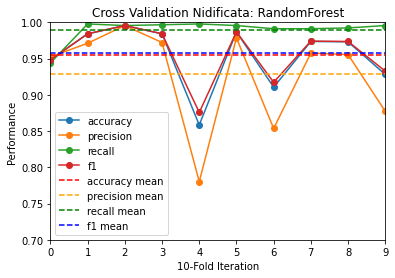

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Parametri  SVM  iterazione  0  : {'C': 100.0, 'kernel': 'rbf'}
Parametri  SVM  iterazione  1  : {'C': 100.0, 'kernel': 'rbf'}
Parametri  SVM  iterazione  2  : {'C': 100.0, 'kernel': 'rbf'}
Parametri  SVM  iterazione  3  : {'C': 100.0, 'kernel': 'rbf'}
Parametri  SVM  iterazione  4  : {'C': 100.0, 'kernel': 'rbf'}
Parametri  SVM  iterazione  5  : {'C': 100.0, 'kernel': 'rbf'}
Parametri  S

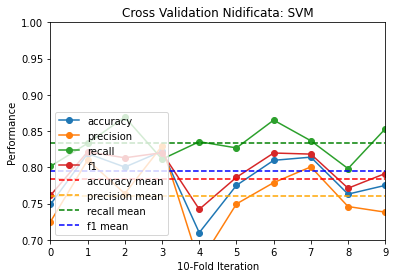

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Parametri  KNN  iterazione  0  : {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Parametri  KNN  iterazione  1  : {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Parametri  KNN  iterazione  2  : {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Parametri  KNN  i

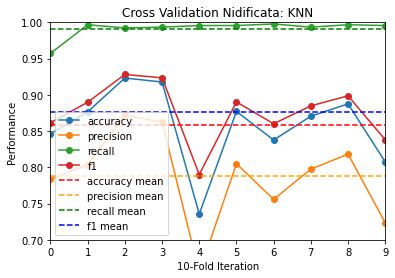

In [17]:
dataset=loadingDataSet(DATASET_NAME)
dataset_copy=dataset.copy()
dataset_noLable=dataset.drop(['id','nameProject','testCase','isFlaky'],axis=1)
dataset_lable=dataset['isFlaky']
dataset_lable=dataset_lable.astype(int)
sc=StandardScaler()
X_dataset=sc.fit_transform(dataset_noLable)
pca=PCA(n_components=10)
principalCompontent=pca.fit_transform(X_dataset)
pca_dataset=pandas.DataFrame(principalCompontent,columns=['Principal Component 1','Principal Component 2','Principal Component  3',
                                                                'Principal Component 4','Principal Component 5','Principal Component 6',
                                                                'Principal Component 7','Principal Component 8','Principal Component 9',
                                                                'Principal Component 10'])
sm=SMOTE(sampling_strategy='auto', k_neighbors=1,random_state=42)
X_dataset,Y_dataset=sm.fit_resample(pca_dataset,dataset_lable)
X_dataset=X_dataset.to_numpy()
Y_dataset=Y_dataset.to_numpy()


clf1=SVC()
clf2=RandomForestClassifier()
clf3=KNeighborsClassifier()
clf_labels=['RandomForest','SVM','KNN']



skf = StratifiedKFold(n_splits=10,shuffle=False)


scores={
    'accuracy':[],
    'precision':[],
    'recall':[],
   'f1':[]
}

grideSearch_SVM=[
    {
	    'C':[0.001,0.01,0.1,1.0,10.0,100.0],
	    'kernel':['linear','rbf'],
    }
]

grideSearch_RF=[
    {
        'n_estimators': [20, 50, 100, 150],
        'criterion': ['gini', 'entropy'],
    }
]

grideSearch_KNN=[
    {
        'n_neighbors': [1, 10, 20, 30],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
]
best_params=[]
for clf,label,grid_param in zip([clf2,clf1,clf3],clf_labels,[grideSearch_RF,grideSearch_SVM,grideSearch_KNN]):
    best_params.clear()
    scores['accuracy'].clear()
    scores['precision'].clear()
    scores['recall'].clear()
    scores['f1'].clear()
    for train_index,test_index in skf.split(X=X_dataset,y=Y_dataset):
        #Creo il set di train e test
        X_train, X_test = X_dataset[train_index], X_dataset[test_index]
        y_train, y_test = Y_dataset[train_index], Y_dataset[test_index]
        
        grid_clf=GridSearchCV(clf,param_grid=grid_param,cv=3,scoring='average_precision',verbose=True,n_jobs=-1)
        grid_clf.fit(X=X_train,y=y_train) #Eseguo la grid search sulla parte di training
        best_params.append(grid_clf.best_params_)
        clf.set_params(**grid_clf.best_params_)
        
        #Addestro il classificatore sul set di train
        clf.fit(X=X_train,y=y_train)
        #Testo il classificatore
        y_predict=clf.predict(X_test)

        #Salvo Accuracy,Precision,Recall,F1
        scores['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_predict))
        scores['precision'].append(precision_score(y_true=y_test, y_pred=y_predict))
        scores['recall'].append(recall_score(y_true=y_test, y_pred=y_predict))
        scores['f1'].append(f1_score(y_true=y_test, y_pred=y_predict))

    i=0
    for best_param in best_params:
        print("Parametri ",label," iterazione ",i," :",best_param)
        i=i+1
    print_scores_cv(scores,label)

L'algoritmo con le prestazioni migliori risulta essere ancora il Random Forest, dove nella media si avranno prestazioni al disopra del 90% e nel caso peggiore si abbasseranno all 80%.
La sua migliore configurazione per il nostro ambiente risulta essere {'criterion': 'gini', 'n_estimators': 100} oppure {'criterion': 'entropy', 'n_estimators': 100}